In [1]:
## standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

fpath=('Data/sales_predictions_2023.csv')
# read in data
df= pd.read_csv(fpath)

In [2]:
# function to summarize df
def summarize_df(df_):
    df = df_.copy()
    report = pd.DataFrame({
                        'dtype':df.dtypes,
                        '# null': df.isna().sum(),
                        'null (%)': df.isna().sum()/len(df)*100,
                        'nunique':df.nunique(),
                        "min":df.min(),
                        'max':df.max()
             })
    report.index.name='Column'
    return report.reset_index()
summarize_df(df)

C:\Users\clove\AppData\Local\Temp\ipykernel_17544\3257411755.py:9: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  "min":df.min(),
C:\Users\clove\AppData\Local\Temp\ipykernel_17544\3257411755.py:10: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  'max':df.max()


,Column,dtype,# null,null (%),nunique,min,max
0,Item_Fat_Content,object,0,0.000000,5,LF,reg
1,Item_Identifier,object,0,0.000000,1559,DRA12,NCZ54
2,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
3,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648
4,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
5,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
6,Item_Weight,float64,1463,17.165317,415,4.555,21.35
7,Outlet_Establishment_Year,int64,0,0.000000,9,1985,2009
8,Outlet_Identifier,object,0,0.000000,10,OUT010,OUT049
9,Outlet_Location_Type,object,0,0.000000,3,Tier 1,Tier 3


In [3]:
#placeholder to impute later
df['Outlet_Size']=df['Outlet_Size'].fillna('MISSING')
# Drop unnessecary columns
df= df.drop(columns=['Item_Identifier','Outlet_Establishment_Year','Outlet_Type','Outlet_Location_Type','Outlet_Identifier'])
# address inconsistent values in fat content.
df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':"Low Fat",'low fat':"Low Fat", 'reg':"Regular"})


In [4]:
summarize_df(df)

,Column,dtype,# null,null (%),nunique,min,max
0,Item_Weight,float64,1463,17.165317,415,4.555,21.35
1,Item_Fat_Content,object,0,0.000000,2,Low Fat,Regular
2,Item_Visibility,float64,0,0.000000,7880,0.0,0.328391
3,Item_Type,object,0,0.000000,16,Baking Goods,Starchy Foods
4,Item_MRP,float64,0,0.000000,5938,31.29,266.8884
5,Outlet_Size,object,0,0.000000,4,High,Small
6,Item_Outlet_Sales,float64,0,0.000000,3493,33.29,13086.9648


## Train Test Split

- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.


In [5]:
## Make x and y variables
y = df['Item_Outlet_Sales'].copy()
X = df.drop(columns=['Item_Outlet_Sales']).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size
8269,7.220,Regular,0.064142,Baking Goods,61.2510,MISSING
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,Medium
2762,12.150,Low Fat,0.028593,Household,151.0708,Small
6464,5.945,Low Fat,0.093009,Household,127.8652,Small
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,Small


In [6]:
## make categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')

## make numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')

In [7]:
for col in cat_sel(X):
    print(f"For {col}:\n{X[col].unique()}\n")

For Item_Fat_Content:
['Low Fat' 'Regular']

For Item_Type:
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

For Outlet_Size:
['Medium' 'MISSING' 'High' 'Small']



In [8]:

drop_cats=['Regular','Others','MISSING']


## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop=drop_cats, sparse_output=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()


X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Item_Fat_Content_Low Fat,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small
8077,15.25,0.061531,132.2968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2391,17.85,0.044463,127.1020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
163,7.27,0.071078,114.2518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
    - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

In [9]:
# define linreg function 
def evaluate_regression(model, X_train,y_train, X_test, y_test):    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")
    
    
# define  coef grabber function
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [10]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.38	RMSE= 1326.28
Test Data:	R^2= 0.38	RMSE= 1381.50


In [11]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs


Item_Visibility                   -3589.503601
Item_Fat_Content_Low Fat            -28.542459
Item_Weight                          -0.110552
Item_MRP                             15.567486
Item_Type_Soft Drinks                20.319280
Item_Type_Meat                       29.251410
Item_Type_Health and Hygiene         44.232879
Item_Type_Household                  44.543167
Outlet_Size_Small                    61.808378
Item_Type_Dairy                      70.158508
Item_Type_Snack Foods                99.579041
Item_Type_Breads                    105.076865
Item_Type_Baking Goods              125.177440
Item_Type_Frozen Foods              136.617109
Item_Type_Breakfast                 148.983037
Item_Type_Canned                    154.415911
Item_Type_Fruits and Vegetables     158.239609
Item_Type_Seafood                   161.167545
Item_Type_Hard Drinks               184.155867
Item_Type_Starchy Foods             203.970540
Outlet_Size_High                    441.826300
Outlet_Size_M

In [12]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

<Axes: title={'center': 'Top 3 Largest Coefficients'}, xlabel='Coefficient', ylabel='Feature Names'>

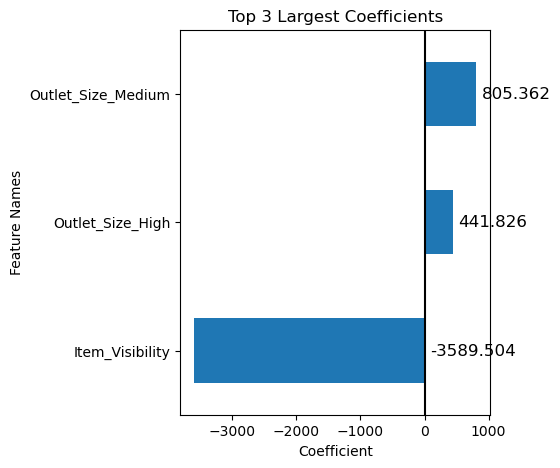

In [13]:
plot_coeffs(coeffs,top_n=3,annotate=True)

- top 3 -

    - outlet size:
- positive effect:
    - outlet_size_medium: if the store falls into the category of a meduim sized store(based on overall size of ground area covered of the location), an additional 805.36 predicted sales can be assumed.
    - outlet_size_high: if the store falls into the category of a high/large sized store(based on overall size of ground area covered of the location) an additional 441.82 predicted sales can be assumed.
- negative effect:


    - item_visibility: for every point increase in the total overall percentage of total product display space(for that specific product) an expected loss of 3,589.50 in outlet sales can be assumed.




# Tree-Based Model


- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
- Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

In [14]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.92	RMSE= 471.74
Test Data:	R^2= 0.45	RMSE= 1297.96


In [15]:
reg.feature_importances_

array([0.18605895, 0.16658947, 0.47304367, 0.01124842, 0.00591105,
       0.00388622, 0.00311276, 0.00668015, 0.00736348, 0.00759988,
       0.01047855, 0.00369534, 0.00538468, 0.00886301, 0.00487137,
       0.00174354, 0.01038319, 0.00543469, 0.00359625, 0.01091049,
       0.04811047, 0.01503437])

In [16]:
## Checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_) == len(X_train_df.columns)

22
22


True

In [17]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Item_Weight                        0.186059
Item_Visibility                    0.166589
Item_MRP                           0.473044
Item_Fat_Content_Low Fat           0.011248
Item_Type_Baking Goods             0.005911
Item_Type_Breads                   0.003886
Item_Type_Breakfast                0.003113
Item_Type_Canned                   0.006680
Item_Type_Dairy                    0.007363
Item_Type_Frozen Foods             0.007600
Item_Type_Fruits and Vegetables    0.010479
Item_Type_Hard Drinks              0.003695
Item_Type_Health and Hygiene       0.005385
Item_Type_Household                0.008863
Item_Type_Meat                     0.004871
Item_Type_Seafood                  0.001744
Item_Type_Snack Foods              0.010383
Item_Type_Soft Drinks              0.005435
Item_Type_Starchy Foods            0.003596
Outlet_Size_High                   0.010910
Outlet_Size_Medium                 0.048110
Outlet_Size_Small                  0.015034
Name: Feature Importance, dtype:

In [18]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Item_MRP                           0.473044
Item_Weight                        0.186059
Item_Visibility                    0.166589
Outlet_Size_Medium                 0.048110
Outlet_Size_Small                  0.015034
Item_Fat_Content_Low Fat           0.011248
Outlet_Size_High                   0.010910
Item_Type_Fruits and Vegetables    0.010479
Item_Type_Snack Foods              0.010383
Item_Type_Household                0.008863
Item_Type_Frozen Foods             0.007600
Item_Type_Dairy                    0.007363
Item_Type_Canned                   0.006680
Item_Type_Baking Goods             0.005911
Item_Type_Soft Drinks              0.005435
Item_Type_Health and Hygiene       0.005385
Item_Type_Meat                     0.004871
Item_Type_Breads                   0.003886
Item_Type_Hard Drinks              0.003695
Item_Type_Starchy Foods            0.003596
Item_Type_Breakfast                0.003113
Item_Type_Seafood                  0.001744
Name: Feature Importance, dtype:

<Axes: >

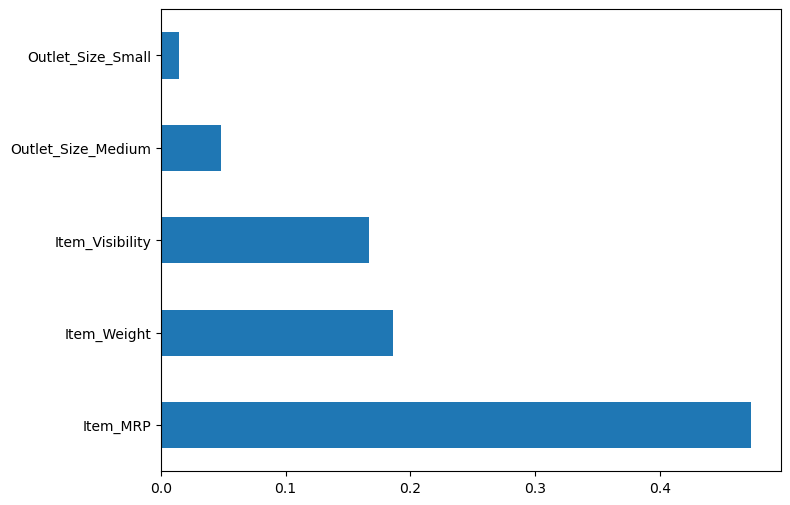

In [19]:
## just keep the top 5 importances and plot
sorted_importance.head(5).plot(kind='barh',
                                   figsize=(8,6))

### top 5 most important features
1. item_mrp
2. item_weight
3. item_visibility
4. outlet size - medium
5. outlet size - small



# Serialize Your Best Models with Joblib
- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
    - "preprocessor": your preprocessing  column transformer
    - "X_train": your training features.
    - "X_test": your test features.
    - "y_train": your training target.
    - "y_test": your test target.
    - "LinearRegression": your best linear regression
    - Your tree-based model's class name: your best tree-based model.
        - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
    - Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

In [20]:
## Fitting and evaluating the model for export.
reg = RandomForestRegressor()
reg.fit(X_train_df, y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.92	RMSE= 471.74
Test Data:	R^2= 0.45	RMSE= 1297.96


In [21]:
## fitting a linear regression model for export
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.38	RMSE= 1326.28
Test Data:	R^2= 0.38	RMSE= 1381.50


In [22]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForestRegressor':reg,
         'LinearRegression':lin_reg}
joblib.dump(export, 'best_models.joblib')

['best_models.joblib']